In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
import json
from scipy.signal import savgol_filter
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [2]:
def toDataFrame(glob_path, col_name, col_index, method=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    df['epoch'] = df.index + 1
    df = df.melt(id_vars=['epoch'])
    df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        df['method'] = method

    return df

def toChunkedDataFrame(glob_path, col_name, col_index, chunk_size, method=None):
    d = [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    # Create a DataFrame where each column is the series of values from a run.
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    
    result_df = pd.DataFrame()
    for col in df.columns:
        arr = df[col].values
        n = len(arr)
        remainder = n % chunk_size
        # If the length isn't a multiple of chunk_size, pad it.
        if remainder != 0:
            pad_length = chunk_size - remainder
            # Use the mean of the last (incomplete) chunk for padding.
            pad_value = arr[-remainder:].mean()
            padded_arr = np.concatenate([arr, np.full(pad_length, pad_value)])
        else:
            padded_arr = arr
        reshaped_data = padded_arr.reshape(-1, chunk_size)
        result_df[col] = reshaped_data.mean(axis=1)
    
    result_df.reset_index(drop=True, inplace=True)
    result_df['epoch'] = result_df.index + 1
    result_df = result_df.melt(id_vars=['epoch'])
    result_df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        result_df['method'] = method
    
    return result_df

def get_final_labels_and_stats(data, epoch_col="epoch", value_col="value", group_col="method",
                               label_format="{label} ({mean:.3f} SE {sem:.3f})"):
    """
    Computes final aggregated stats and creates new legend labels, preserving the original order.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the data with columns for epoch, value, and group identifier.
    epoch_col : str, default "epoch"
        Column name representing the epoch.
    value_col : str, default "value"
        Column name for the metric values.
    group_col : str, default "method"
        Column name used to group the data.
    label_format : str, default "{label}: {mean:.3f} ± {sem:.3f}"
        A format string used to create new legend labels, where {label} is the group,
        {mean} is the computed mean, and {sem} is the standard error.

    Returns:
    --------
    new_labels : list of str
        A list of updated legend labels with the final aggregated values in the original order.
    final_stats : pd.DataFrame
        A DataFrame indexed by the group column containing the mean and standard error,
        reindexed to preserve the original order of appearance.
    """
    # Determine the final epoch
    final_epoch = data[epoch_col].max()

    # Filter data to only include the final epoch
    final_data = data[data[epoch_col] == final_epoch]

    # Compute aggregated statistics (mean and standard error) grouped by the given group column
    final_stats = final_data.groupby(group_col)[value_col].agg(["mean", "sem"])

    # Get the original order of methods as they first appear in the data
    original_order = data[group_col].drop_duplicates().tolist()

    # Reindex final_stats to follow the original order (dropping any methods that might be missing)
    final_stats = final_stats.reindex(original_order)

    # Create new labels in the preserved order
    new_labels = []
    for label in original_order:
        if label in final_stats.index and pd.notnull(final_stats.loc[label, "mean"]):
            new_label = label_format.format(label=label,
                                            mean=final_stats.loc[label, "mean"],
                                            sem=final_stats.loc[label, "sem"])
        else:
            new_label = label
        new_labels.append(new_label)
    
    return new_labels


# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[4], palette[2], palette[5], palette[6]])
# sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.15)

       epoch seed     value      method
0          1    0  1.060839  Adam Fixed
1          2    0  0.934124  Adam Fixed
2          3    0  0.962286  Adam Fixed
3          4    0  0.598814  Adam Fixed
4          5    0  0.963103  Adam Fixed
...      ...  ...       ...         ...
11995    296    9  0.047697  Tuned CAWR
11996    297    9  0.052414  Tuned CAWR
11997    298    9  0.045361  Tuned CAWR
11998    299    9  0.048414  Tuned CAWR
11999    300    9  0.046507  Tuned CAWR

[12000 rows x 4 columns]


/home/micha/Studium/BA_new/BA-Parameter-Free-DAC/ba_parameter_free_dac/plotting/plotting.py:208: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.lineplot(data=data, x=x, y=y, ax=ax, marker=marker, hue=hue, errorbar=errorbar, estimator=aggregation,palette=palette if palette is not None else sns.color_palette('colorblind', as_cmap = True))
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


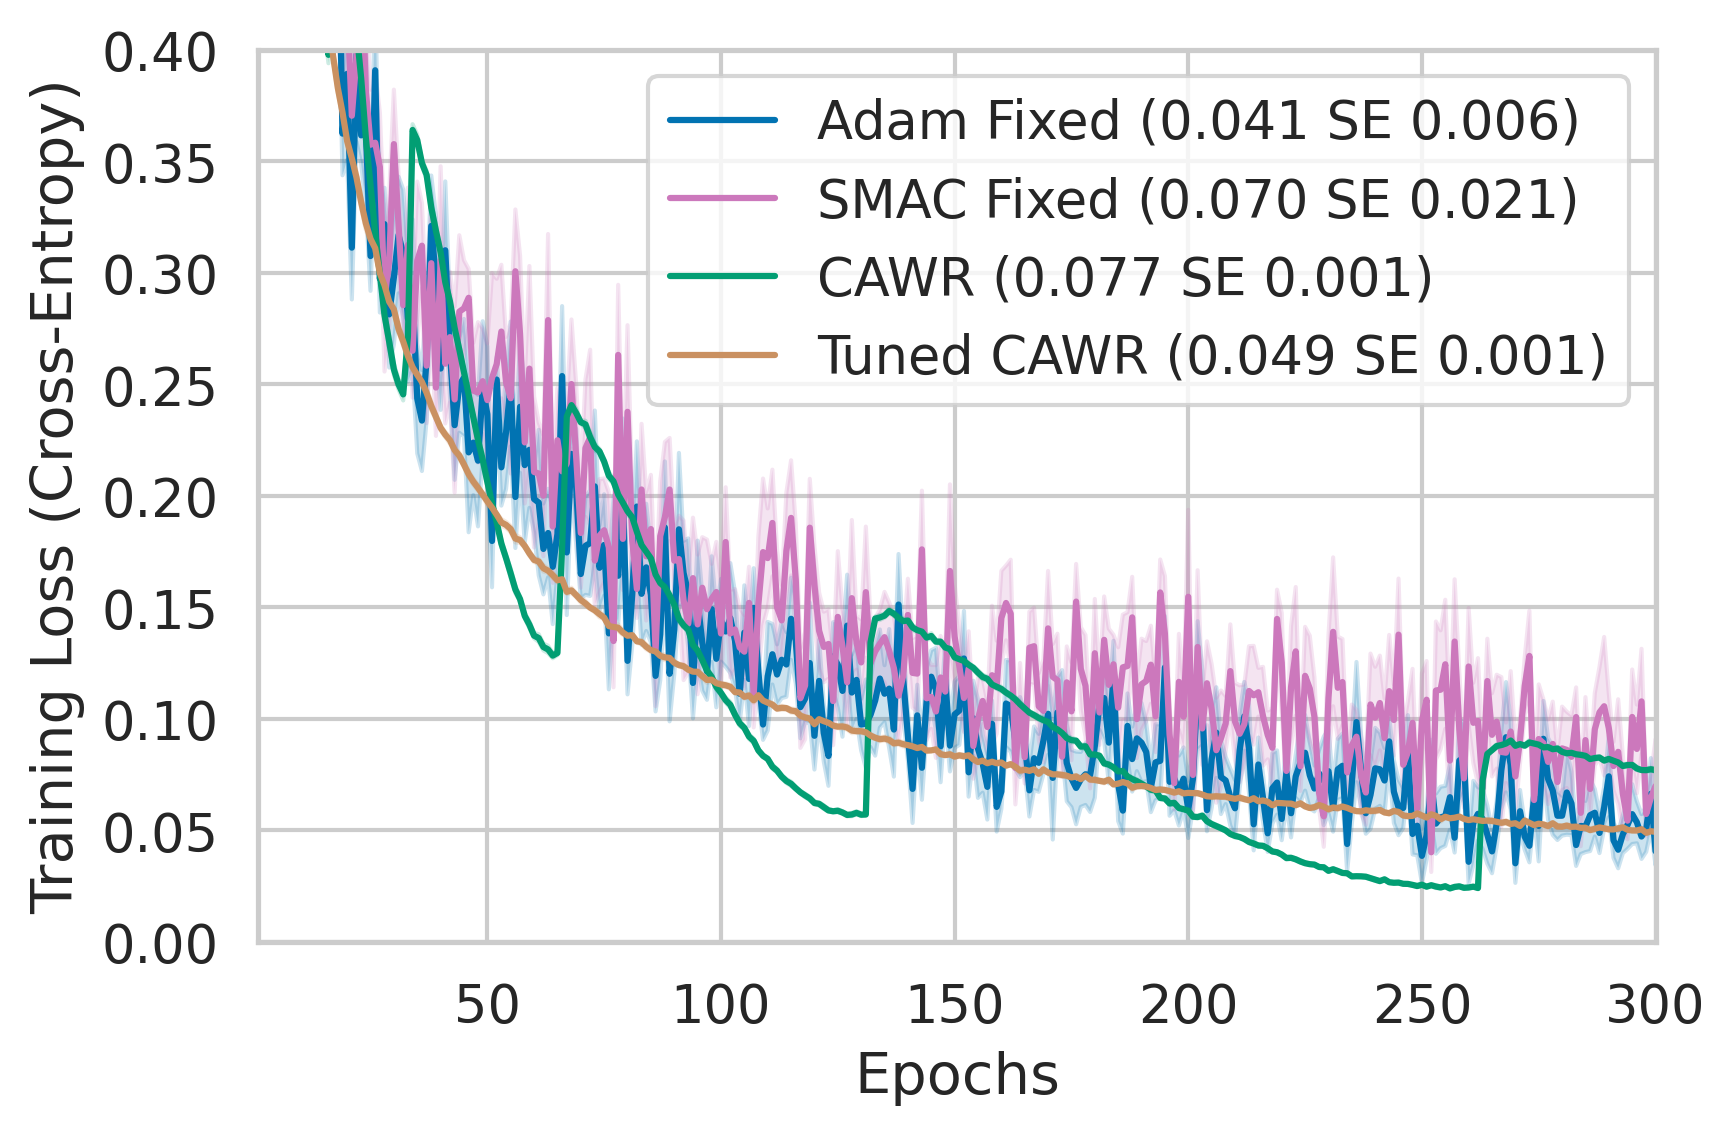

In [7]:
metric = 'training_losses'
metric_idx = 3

smacfixed_tl = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', metric, metric_idx, method='SMAC Fixed')
cawr_tl = toChunkedDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 625, method='CAWR')
tuned_cawr_tl = toChunkedDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 625, method='Tuned CAWR')
adam_fixed_tl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', metric, metric_idx, method='Adam Fixed')
adam_fixed_tl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', metric, metric_idx, method='Adam Fixed')

# 'seed', 'epoch', 'method', 'training_loss'
data_tl = pd.concat([adam_fixed_tl, smacfixed_tl, cawr_tl, tuned_cawr_tl], ignore_index=True)
print(data_tl)
# data['value'] = data.groupby(['method', 'seed'])['value'] \
#                         .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
                        # .transform(lambda x: savgol_filter(x, window_length=11, polyorder=3))
fig = _plot_performance_over_time(
    data_tl,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    errorbar='se',
    logy=False,
    xlabel="Epochs",
    ylabel="Training Loss (Cross-Entropy)",
    ylim=(0, 0.4),
    palette=palette,
    )
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data_tl), loc="upper right", bbox_to_anchor=(1, 1),
          ncol=1, title=None, frameon=True)

/home/micha/Studium/BA_new/BA-Parameter-Free-DAC/ba_parameter_free_dac/plotting/plotting.py:208: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.lineplot(data=data, x=x, y=y, ax=ax, marker=marker, hue=hue, errorbar=errorbar, estimator=aggregation,palette=palette if palette is not None else sns.color_palette('colorblind', as_cmap = True))
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


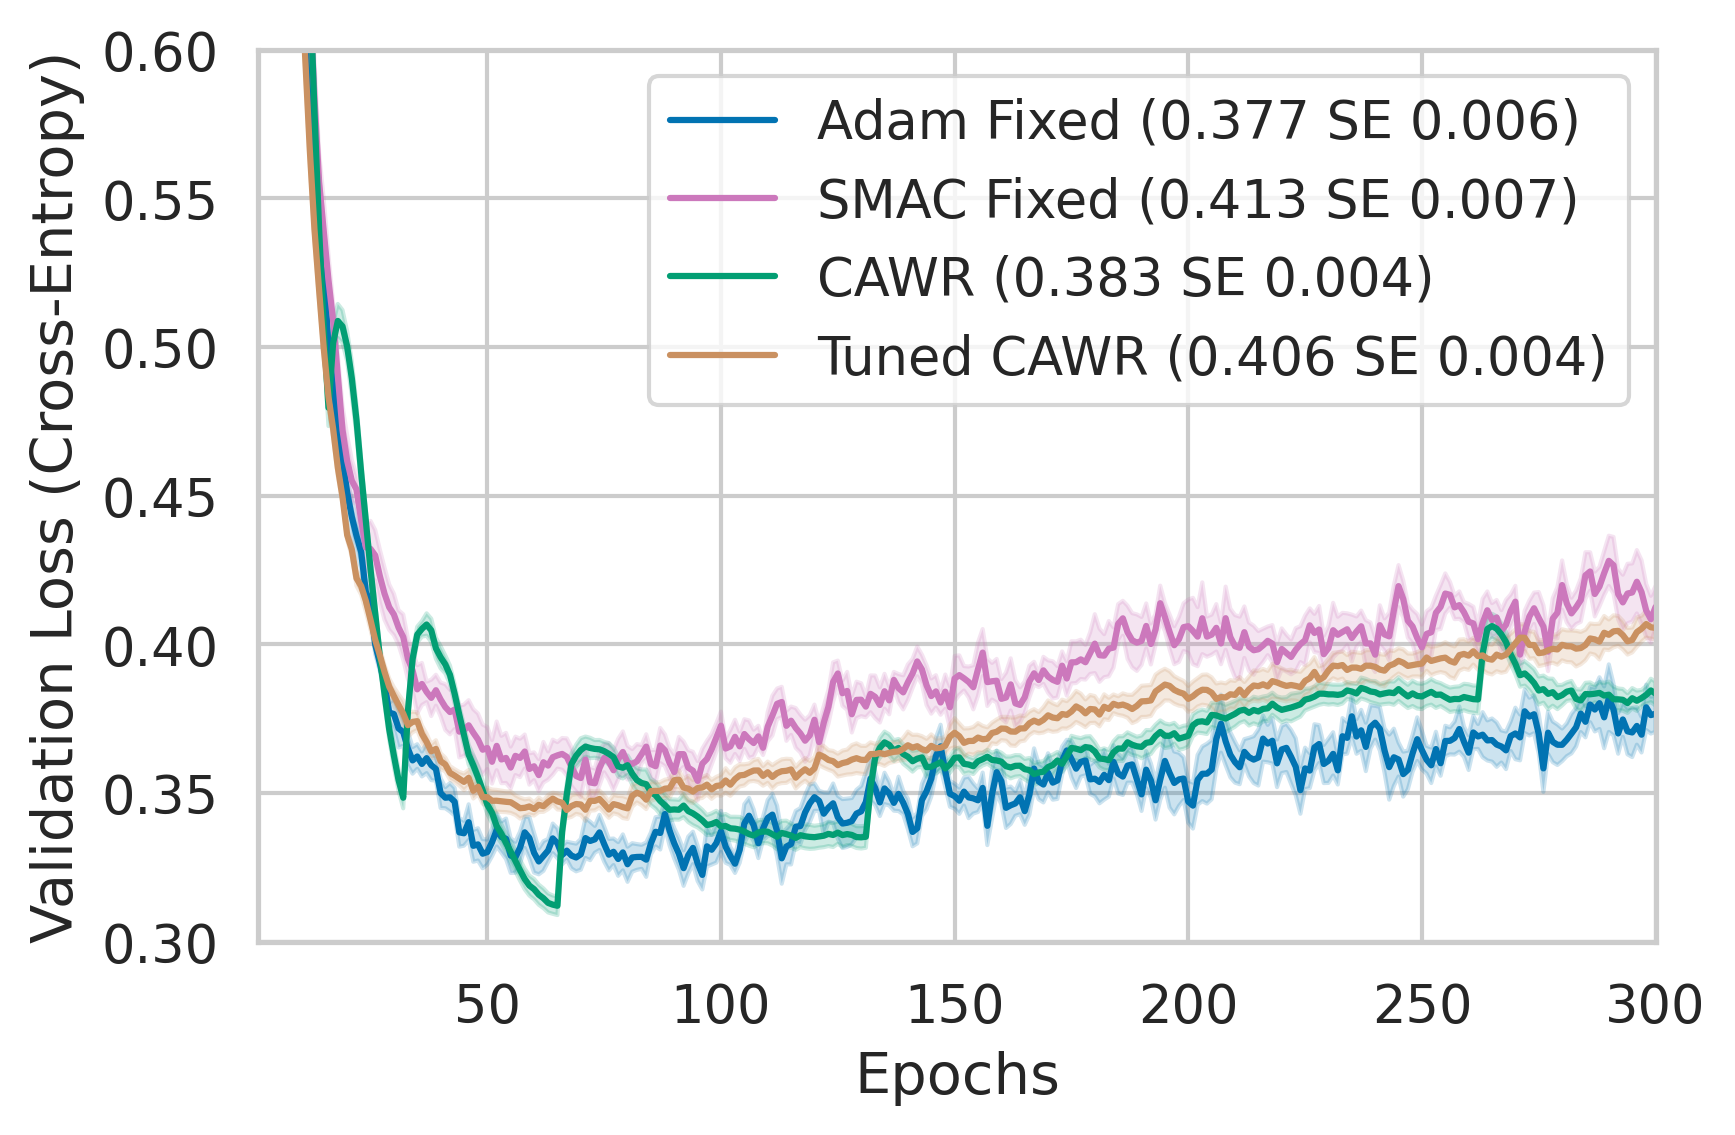

In [8]:
smacfixed_vl = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='SMAC Fixed')
cawr_vl = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='CAWR')
tuned_cawr_vl = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Tuned CAWR')
adam_fixed_vl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'Adam Fixed')


# 'seed', 'epoch', 'method', 'training_loss'

data_vl = pd.concat([adam_fixed_vl, smacfixed_vl, cawr_vl, tuned_cawr_vl], ignore_index=True)
data_vl['value'] = data_vl.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
# print(tuned_cawr_vl)
fig = _plot_performance_over_time(
    data_vl,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    errorbar="se",
    logy=False,
    xlabel="Epochs",
    ylabel="Validation Loss (Cross-Entropy)",
    ylim=(0.3,0.6),
    palette=palette)
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data_vl), loc="upper right", bbox_to_anchor=(1, 1),
          ncol=1, title=None, frameon=True)

/home/micha/Studium/BA_new/BA-Parameter-Free-DAC/ba_parameter_free_dac/plotting/plotting.py:208: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.lineplot(data=data, x=x, y=y, ax=ax, marker=marker, hue=hue, errorbar=errorbar, estimator=aggregation,palette=palette if palette is not None else sns.color_palette('colorblind', as_cmap = True))
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


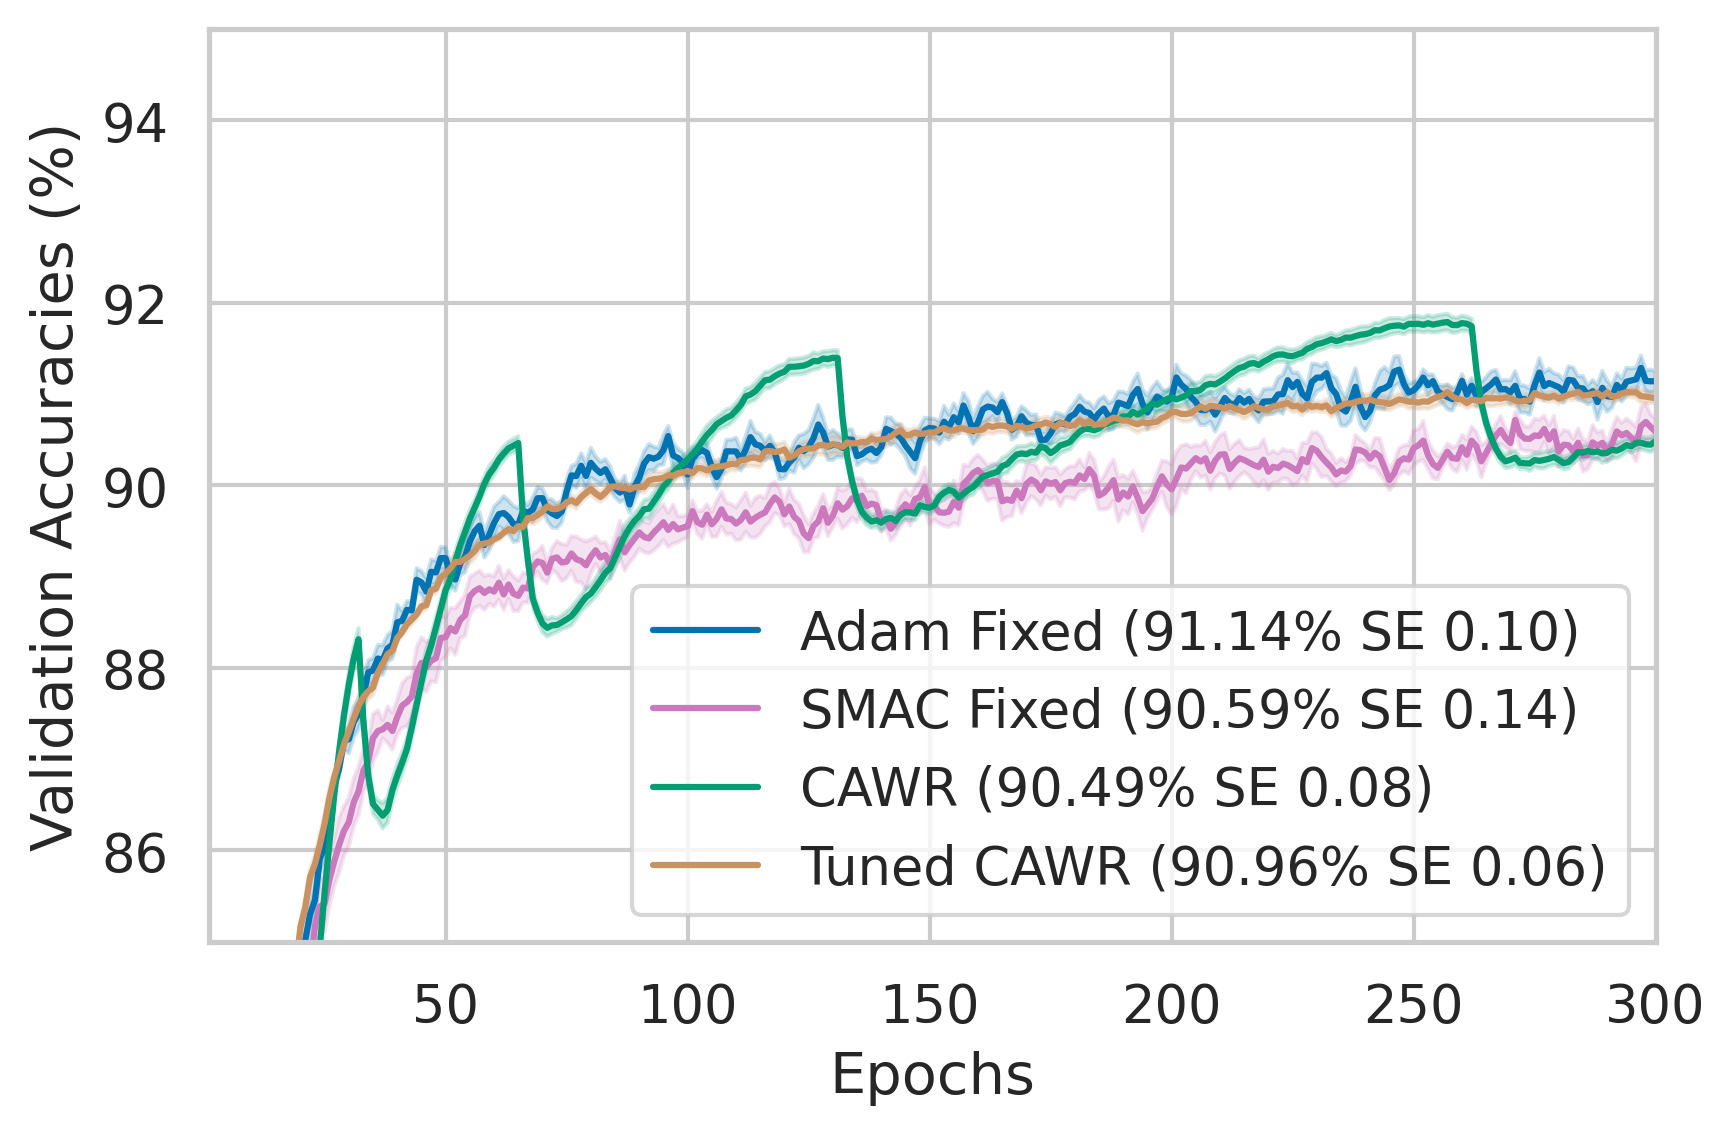

In [9]:
smacfixed_va = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='SMAC Fixed')
cawr_va = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='CAWR')
tuned_cawr_va = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Tuned CAWR')
adam_fixed_va = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'Adam Fixed')

# 'seed', 'epoch', 'method', 'training_loss'

data_va = pd.concat([adam_fixed_va, smacfixed_va, cawr_va, tuned_cawr_va], ignore_index=True)
data_va['value'] = data_va.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())

data_va['value'] = data_va['value'] * 100 # convert to percent
fig = _plot_performance_over_time(
    data_va,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    logy=False,
    xlabel="Epochs",
    ylabel="Validation Accuracies (%)",
    ylim=(85, 95),
    errorbar="se",
    palette=palette)
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data_va, label_format="{label} ({mean:.2f}% SE {sem:.2f})"), loc="lower right", bbox_to_anchor=(1, 0),
          ncol=1, title=None, frameon=True)

In [21]:
smacfixed_va = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='SMAC Fixed')
cawr_va = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='CAWR')
tuned_cawr_va = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Tuned CAWR')
adam_fixed_va = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'Adam Fixed')
cocob_va = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB')
dadaptation_va = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation')
prodigy_va = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy')
dowg_va = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'DoWG')
data_va = pd.concat([adam_fixed_va, smacfixed_va, cawr_va, tuned_cawr_va, dadaptation_va, prodigy_va, cocob_va, dowg_va], ignore_index=True)

smacfixed_vl = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='SMAC Fixed')
cawr_vl = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='CAWR')
tuned_cawr_vl = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Tuned CAWR')
adam_fixed_vl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'Adam Fixed')
cocob_vl = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='COCOB')
dadaptation_vl = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='D-Adaptation')
prodigy_vl = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Prodigy')
dowg_vl = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'DoWG')
data_vl = pd.concat([adam_fixed_vl, smacfixed_vl, cawr_vl, tuned_cawr_vl, dadaptation_vl, prodigy_vl, cocob_vl, dowg_vl], ignore_index=True)

cocob_tl = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB')
dadaptation_tl = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation')
prodigy_tl = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy')
adam_fixed_tl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'Adam Fixed')
dowg_tl = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'DoWG')

data_tl = pd.concat([adam_fixed_tl, smacfixed_tl, cawr_tl, tuned_cawr_tl, dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)

data_tl = data_tl.rename(columns={"value": "training_loss"})
data_vl = data_vl.rename(columns={"value": "validation_loss"})
data_va = data_va.rename(columns={"value": "validation_accuracy"})
data = data_tl.merge(data_vl, on=["method", "epoch", "seed"]).merge(data_va, on=["method", "epoch", "seed"])
print(data)
data.to_csv('experiments_cifar10.csv', index=False)


       epoch seed  training_loss      method  validation_loss  \
0          1    0       1.060839  Adam Fixed         1.231932   
1          2    0       0.934124  Adam Fixed         1.025473   
2          3    0       0.962286  Adam Fixed         0.925444   
3          4    0       0.598814  Adam Fixed         0.800371   
4          5    0       0.963103  Adam Fixed         0.743018   
...      ...  ...            ...         ...              ...   
23995    296    9       0.046441        DoWG         0.419926   
23996    297    9       0.017488        DoWG         0.621956   
23997    298    9       0.132289        DoWG         0.366525   
23998    299    9       0.050430        DoWG         0.441434   
23999    300    9       0.374894        DoWG         0.456001   

       validation_accuracy  
0                 0.553711  
1                 0.649414  
2                 0.675781  
3                 0.715820  
4                 0.732422  
...                    ...  
23995           

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Best method determined from data: Adam Fixed
_child0 Adam Fixed
DONE
_child2 Adam Fixed
_child4 Adam Fixed
_child6 Adam Fixed
Adam Fixed Adam Fixed
DONE
SMAC Fixed Adam Fixed
CAWR Adam Fixed
Tuned CAWR Adam Fixed


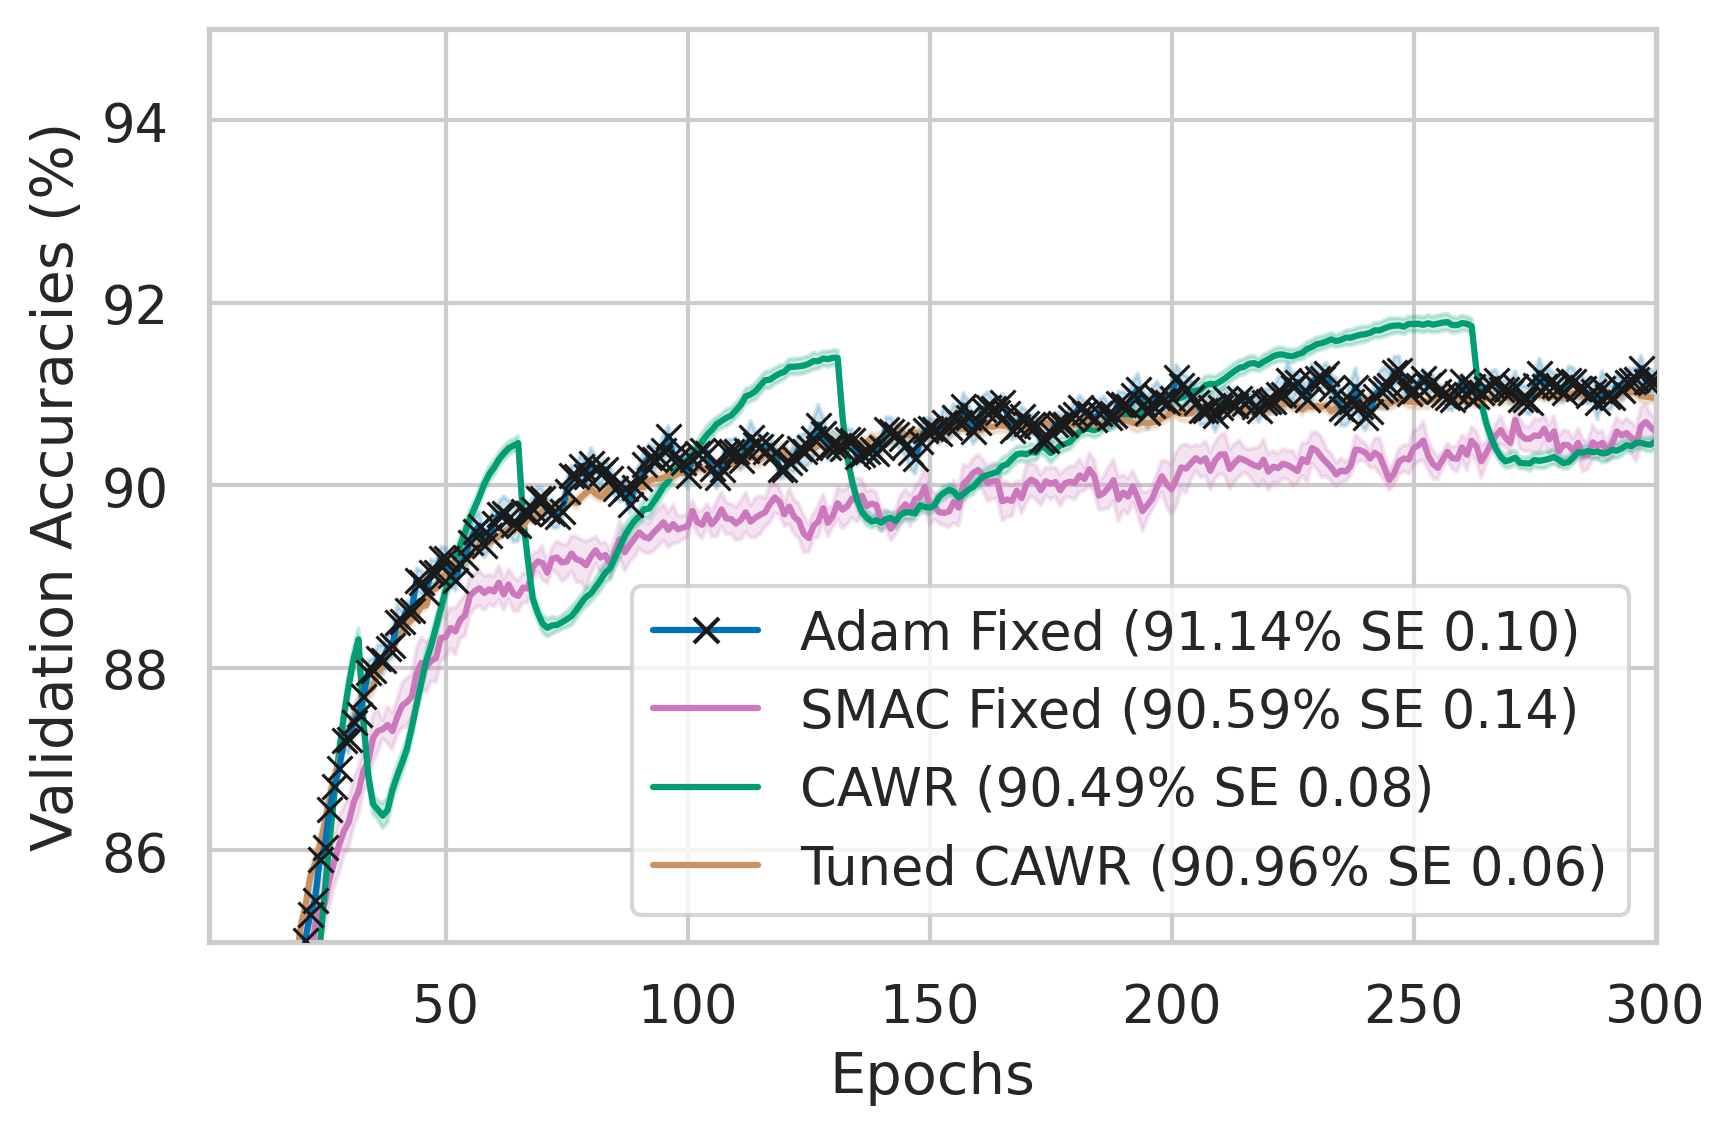

In [ ]:
# Load your data for each method
smacfixed_va = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl',
                            'validation_accuracies', 6, method='SMAC Fixed')
cawr_va = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl',
                      'validation_accuracies', 6, method='CAWR')
tuned_cawr_va = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl',
                            'validation_accuracies', 6, method='Tuned CAWR')
adam_fixed_va = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl',
                            'validation_accuracies', 6, 'Adam Fixed')

# Combine the data from all methods
data = pd.concat([adam_fixed_va, smacfixed_va, cawr_va, tuned_cawr_va], ignore_index=True)

# Smooth the data per method/seed and convert to percent
data['value'] = data.groupby(['method', 'seed'])['value'].transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
data['value'] = data['value'] * 100  # convert to percent

# Create the lineplot using your plotting function
fig = _plot_performance_over_time(
    data,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    logy=False,
    xlabel="Epochs",
    ylabel="Validation Accuracies (%)",
    ylim=(85, 95),
    errorbar="se",
    palette=palette
)
fig.set_size_inches(6, 4, forward=True)
ax = fig.gca()
ax.set_title("")

# Determine the final epoch and compute the mean final accuracy per method.
final_epoch = data['epoch'].max()
final_df = data[data['epoch'] == final_epoch].groupby('method', as_index=False)['value'].mean()

# The best method is the one with the highest final accuracy.
best_method = final_df.loc[final_df['value'].idxmax(), 'method']
print("Best method determined from data:", best_method)

# Loop over all axes and lines, print debug info, and update the best method's line.

for line in ax.lines:
    print(line.get_label(), best_method)
    if line.get_label() == "_child0" or line.get_label() == best_method:
        line.set_linewidth(1.5)
        print("DONE")
        line.set_marker('x')
        line.set_markeredgecolor('k')
        line.set_markersize(8)
        line.set_markeredgecolor('k')
        line.set_zorder(10)
plt.draw()
# Instead of relying on get_ydata(), compute the final y-value directly from the data.
final_y = data[(data['method'] == best_method) & (data['epoch'] == final_epoch)]['value'].mean()

# Re-add the legend with your custom labels.
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles,
    get_final_labels_and_stats(data, label_format="{label} ({mean:.2f}% SE {sem:.2f})"),
    loc="lower right",
    bbox_to_anchor=(1, 0),
    ncol=1,
    title=None,
    frameon=True
)
plt.show()


In [28]:

cocob_t = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='COCOB')
dowg_t = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='DoWG')
dadaptation_t = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='D-Daptation')
prodigy_t = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='Prodigy')
cawr_t = toChunkedDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, 625, method='CAWR')
adam_fixed_t = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='adam_fixed')
smac_fixed_t = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, method='SMAC Fixed')
tuned_cawr_t = toChunkedDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'step_times', 2, 625, method='CAWR')
data = pd.concat([cawr_t, adam_fixed_t, smac_fixed_t, tuned_cawr_t, dowg_t, dadaptation_t, cocob_t, prodigy_t], ignore_index=True)
# print(data)
result = (data.groupby(['method', 'seed'])['value']
            .sum()
            .groupby('method')
            .mean()
            .reset_index()
         )
result.rename(columns={'value': 'sum_epochs_avg_seeds'}, inplace=True)
print(result)

        method  sum_epochs_avg_seeds
0         CAWR          3.043386e+05
1        COCOB          6.323445e+07
2  D-Daptation          6.675419e+07
3         DoWG          4.939479e+07
4      Prodigy          6.675419e+07
5   SMAC Fixed          2.334758e+06
6   adam_fixed          8.941812e+07


      epoch seed     value      method
0         1    0  0.019316  SMAC Fixed
1         2    0  0.019316  SMAC Fixed
2         3    0  0.019316  SMAC Fixed
3         4    0  0.019316  SMAC Fixed
4         5    0  0.019316  SMAC Fixed
...     ...  ...       ...         ...
2995    296    9  0.019316  SMAC Fixed
2996    297    9  0.019316  SMAC Fixed
2997    298    9  0.019316  SMAC Fixed
2998    299    9  0.019316  SMAC Fixed
2999    300    9  0.019316  SMAC Fixed

[3000 rows x 4 columns]
    epoch seed  value      method
0       1    0    NaN  Adam Fixed
1       1    1    NaN  Adam Fixed
2       1    2    NaN  Adam Fixed
3       1    3    NaN  Adam Fixed
4       1    4    NaN  Adam Fixed
5       1    5    NaN  Adam Fixed
6       1    6    NaN  Adam Fixed
7       1    7    NaN  Adam Fixed
8       1    8    NaN  Adam Fixed
9       1    9    NaN  Adam Fixed
10      1    0    NaN  SMAC Fixed
11      1    1    NaN  SMAC Fixed
12      1    2    NaN  SMAC Fixed
13      1    3    NaN  SMAC Fix

/home/micha/Studium/BA_new/BA-Parameter-Free-DAC/ba_parameter_free_dac/plotting/plotting.py:207: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.lineplot(data=data, x=x, y=y, ax=ax, marker=marker, hue=hue, errorbar=errorbar, estimator=aggregation,palette=sns.color_palette('colorblind', as_cmap = True))
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyError: 'y'

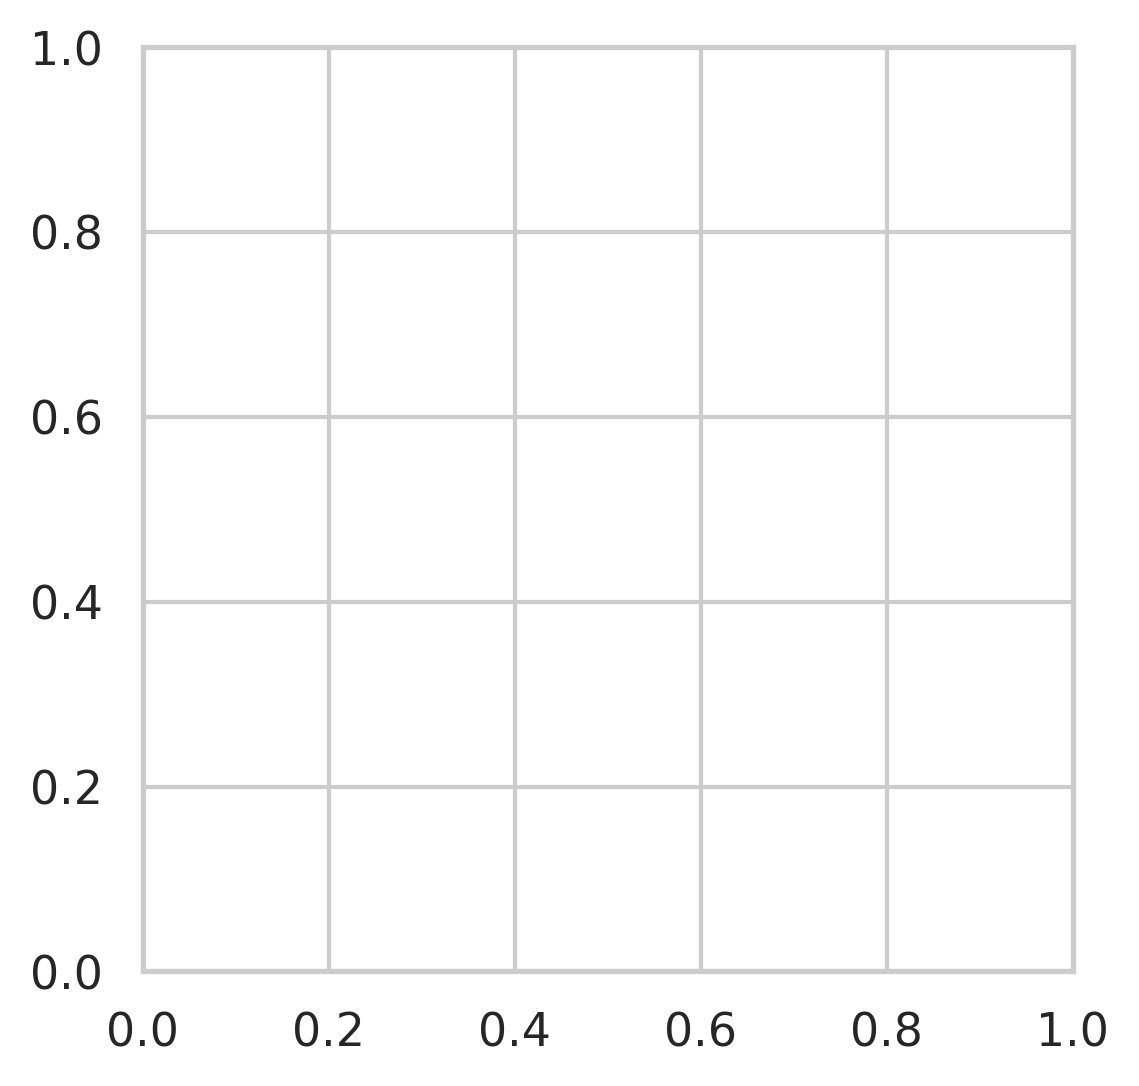

In [63]:
smacfixed_lr = toDataFrame('../results_cluster/results/tuned_smacfixed_cifar10/*/CustomTrackingWrapper.jsonl', 'actions', 1, method='SMAC Fixed')
smacfixed_lr['value'] = smacfixed_lr['value'].str[0].astype(float)
# print(smacfixed_lr)
cawr_lr = toDataFrame('../results_cluster/results/CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'actions', 1, method='CAWR')
# cawr_lr['value'] = cawr_lr['value'].str[0].astype(float)
tuned_cawr_lr = toDataFrame('../results_cluster/results/tuned_CAWR_cifar10/*/CustomTrackingWrapper.jsonl', 'actions', 1, method='Tuned CAWR')
# tuned_cawr_lr['value'] = tuned_cawr_lr['value'].str[0].astype(float)
adam_fixed_lr = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'actions', 1, 'Adam Fixed')
adam_fixed_lr['value'] = adam_fixed_lr['value'].str[0].astype(float)
# 'seed', 'epoch', 'method', 'training_loss'

data = pd.concat([adam_fixed_va, smacfixed_va, cawr_va, tuned_cawr_va], ignore_index=True)
print(data)

fig = _plot_performance_over_time(data, x="epoch", y="value", hue="method", aggregation="mean", logy=False, xlabel="Epochs", ylabel="Learning Rates")
fig.set_size_inches(6, 4, forward=True)